In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pickle
import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import xgboost as xgb
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [3]:
model_path_name = "weight_adv_no_pitch_id_fulled_tuned"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [4]:
if not os.path.exists(DIRECTORY_PATH):
    os.makedirs(DIRECTORY_PATH)
with open(MODEL_INFO_FILEPATH, "w") as text_file:
    print(f"##### MODEL INFO #####", file=text_file)
    print(f"Weighted, no pitcher id, advanced_dataset (no fully properly tuned)", file=text_file)

In [5]:
dataset = pd.read_pickle("data/advanced_dataset_final.pkl")

In [6]:
print(dataset.shape[0]*.80)
print(dataset.shape[0]*.10)

569472.8
71184.1


In [7]:
train_index_stop = 569484 # this is the first index of a new pitcher
val_index_stop = 640690 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

In [8]:
train_X = training_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1)
train_y = training_set['pitch_type']
train_weights = training_set['type_confidence']

val_X = validation_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1)
val_y = validation_set['pitch_type']
val_weights = validation_set['type_confidence']

test_X = test_set.drop(["uid", "pitch_type", "type_confidence", "pitcher_id"],axis=1)
test_y = test_set['pitch_type']
test_weights = test_set['type_confidence']

In [9]:
mapping = {'FF' : 0,
           'SL': 1, 
           'CU': 2, 
           'SI': 3, 
           'FC': 4, 
           'FT': 5, 
           'KC': 6, 
           'CH': 7, 
           'KN': 8, 
           'FS': 9, 
           'FO': 10, 
           'EP': 11, 
           'SC': 12}

In [10]:
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)

In [11]:
val_y.unique()

[0, 5, 4, 2, 7, ..., 3, 11, 8, 12, 10]
Length: 13
Categories (13, int64): [7, 2, 11, 4, ..., 8, 12, 3, 1]

In [23]:
bparams = {'max_depth': 6,
 'learning_rate': 0.23414476853402916,
 'n_estimators': 800,
 'subsample': 0.7000000000000001,
 'min_child_weight': 4}

OBJECTIVE_FUNC = 'objective=multi:softprob'

clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10, n_jobs = -1,
                                        objective=OBJECTIVE_FUNC, eval_metric=['merror','mlogloss'], **bparams)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)],
        sample_weight=train_weights, sample_weight_eval_set=val_weights.values.reshape(1,-1))

[0]	validation_0-merror:0.55670	validation_0-mlogloss:2.19535
[1]	validation_0-merror:0.55151	validation_0-mlogloss:1.99420
[2]	validation_0-merror:0.54946	validation_0-mlogloss:1.85425
[3]	validation_0-merror:0.54643	validation_0-mlogloss:1.74975
[4]	validation_0-merror:0.54483	validation_0-mlogloss:1.66849
[5]	validation_0-merror:0.54443	validation_0-mlogloss:1.60324
[6]	validation_0-merror:0.54323	validation_0-mlogloss:1.55068
[7]	validation_0-merror:0.54282	validation_0-mlogloss:1.50705
[8]	validation_0-merror:0.54207	validation_0-mlogloss:1.47039
[9]	validation_0-merror:0.54138	validation_0-mlogloss:1.43966
[10]	validation_0-merror:0.54118	validation_0-mlogloss:1.41420
[11]	validation_0-merror:0.54028	validation_0-mlogloss:1.39233
[12]	validation_0-merror:0.53919	validation_0-mlogloss:1.37382
[13]	validation_0-merror:0.53921	validation_0-mlogloss:1.35760
[14]	validation_0-merror:0.53917	validation_0-mlogloss:1.34343
[15]	validation_0-merror:0.53904	validation_0-mlogloss:1.33107
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23414476853402916, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [12]:
# clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
#                                         objective='objective=multi:softmax', eval_metric=['merror','mlogloss'])
# clf.fit(train_X, train_y, eval_set=[(val_X, val_y)])

In [14]:
def objective(trial, train_X, train_y, val_X, val_y, train_weights=None, val_weights=None):
    param = {
             "max_depth": trial.suggest_int('max_depth', 2, 100,step=1),
              "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
              "n_estimators": trial.suggest_int('n_estimators', 100, 10000,step=100),
              "subsample" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
              "min_child_weight" : trial.suggest_int('min_child_weight', 1, 10, step=1), 
              "colsample_bytree" : trial.suggest_float('subsample', 0.1, 1, step=0.1),
            }
    OBJECTIVE_FUNC = 'objective=multi:softprob'
    clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                            objective=OBJECTIVE_FUNC, eval_metric=['merror','mlogloss'], **param)
    
    if train_weights is None:
      clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=0)
    else:
       clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], 
               sample_weight=train_weights, sample_weight_eval_set=val_weights, verbose=0)
    
    best_merror = clf.evals_result()['validation_0']['merror'][clf.best_iteration]
    return best_merror


In [15]:
study = optuna.create_study(direction="minimize")
study.optimize(lambda x : objective(x, train_X, train_y, val_X, val_y, train_weights, val_weights.values.reshape(1,-1)), n_trials=5)
print(study.best_trial)

[I 2024-04-21 16:00:09,443] A new study created in memory with name: no-name-95b24292-062e-4373-b540-388062a812ed
[I 2024-04-21 16:00:48,238] Trial 0 finished with value: 0.5255910459268246 and parameters: {'max_depth': 3, 'learning_rate': 0.15136213385247016, 'n_estimators': 100, 'subsample': 0.2, 'min_child_weight': 5}. Best is trial 0 with value: 0.5255910459268246.
[I 2024-04-21 16:04:39,408] Trial 1 finished with value: 0.5175494827384557 and parameters: {'max_depth': 2, 'learning_rate': 0.08887941977334556, 'n_estimators': 800, 'subsample': 0.4, 'min_child_weight': 9}. Best is trial 1 with value: 0.5175494827384557.
[I 2024-04-21 16:14:47,143] Trial 2 finished with value: 0.5006891434175788 and parameters: {'max_depth': 9, 'learning_rate': 0.011224300648307792, 'n_estimators': 900, 'subsample': 1.0, 'min_child_weight': 8}. Best is trial 2 with value: 0.5006891434175788.
[I 2024-04-21 16:23:57,476] Trial 3 finished with value: 0.5188037372203694 and parameters: {'max_depth': 8, 'l

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.4998981263576364], datetime_start=datetime.datetime(2024, 4, 21, 16, 23, 57, 478438), datetime_complete=datetime.datetime(2024, 4, 21, 16, 34, 7, 666986), params={'max_depth': 10, 'learning_rate': 0.012912579249266812, 'n_estimators': 800, 'subsample': 0.8, 'min_child_weight': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8, 9, 10)), 'learning_rate': FloatDistribution(high=0.5, log=True, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=100), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=4, value=None)


In [16]:

print(f"Best Params = {study.best_params}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Params = {study.best_params}", file=text_file)

Best Params = {'max_depth': 10, 'learning_rate': 0.012912579249266812, 'n_estimators': 800, 'subsample': 0.8, 'min_child_weight': 2}


In [29]:
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, early_stopping_rounds=10,
                                        objective='objective=multi:softmax', eval_metric=['merror','mlogloss'], **study.best_params)
clf.fit(train_X, train_y, eval_set=[(val_X, val_y)], sample_weight=train_weights, sample_weight_eval_set=val_weights.values.reshape(1,-1))

[0]	validation_0-merror:0.53204	validation_0-mlogloss:2.53944
[1]	validation_0-merror:0.52344	validation_0-mlogloss:2.51485
[2]	validation_0-merror:0.52097	validation_0-mlogloss:2.49125
[3]	validation_0-merror:0.51986	validation_0-mlogloss:2.46844
[4]	validation_0-merror:0.51715	validation_0-mlogloss:2.44649
[5]	validation_0-merror:0.51669	validation_0-mlogloss:2.42531
[6]	validation_0-merror:0.51613	validation_0-mlogloss:2.40479
[7]	validation_0-merror:0.51522	validation_0-mlogloss:2.38495
[8]	validation_0-merror:0.51507	validation_0-mlogloss:2.36568
[9]	validation_0-merror:0.51481	validation_0-mlogloss:2.34697
[10]	validation_0-merror:0.51389	validation_0-mlogloss:2.32881
[11]	validation_0-merror:0.51391	validation_0-mlogloss:2.31128
[12]	validation_0-merror:0.51346	validation_0-mlogloss:2.29414
[13]	validation_0-merror:0.51296	validation_0-mlogloss:2.27752
[14]	validation_0-merror:0.51346	validation_0-mlogloss:2.26132
[15]	validation_0-merror:0.51344	validation_0-mlogloss:2.24542
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=True, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.012912579249266812, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [15]:
pickle.dump(clf, open(f"{DIRECTORY_PATH}/xgb_model.pkl", "wb"))

In [16]:
best_val_merror = clf.evals_result()['validation_0']['merror'][clf.best_iteration]
best_val_mlogloss = clf.evals_result()['validation_0']['mlogloss'][clf.best_iteration]

print(f"Best Val merror = {best_val_merror}")
print(f"Best Val mlogloss = {best_val_mlogloss}")
with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(f"Best Val merror = {best_val_merror}", file=text_file)
    print(f"Best Val mlogloss = {best_val_mlogloss}", file=text_file)

Best Val merror = 0.5089727076553111
Best Val mlogloss = 1.173586525344724


In [24]:
#y_pred_probs = clf.predict_proba(val_X)

In [17]:
# y_pred_probs = clf.predict_proba(val_X)
y_pred = clf.predict(val_X)

print('\n------------------ Confusion Matrix -----------------\n')
cmatrix = confusion_matrix(val_y, y_pred)
print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print('\n------------------ Confusion Matrix for Full Model -----------------\n', file=text_file)
    print(f"{pd.DataFrame(cmatrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)


------------------ Confusion Matrix -----------------

       FF    SL    CU    SI    FC    FT   KC    CH   KN   FS  FO  EP  SC
FF  16637  2761   845   645   575  1735  117   969  111  196   2   1   2
SL   4371  4331   241   745    90   848   16   233    0   84   0   1   4
CU   2006   490  1288   332   339   673    3   302   17   59   0   0   0
SI    863  1668   437  3912   268    31   51   764    0  167   0   0   0
FC   1342   188   238   281  1627   229   31   268    0    3   0   0   0
FT   2606   944   418    13   184  3795   22   383    0   51   0   0   1
KC    330     8     0    91    41    48  240    70    0    1   0   0   0
CH   2625   627   343   654   238   912   72  1381    0   12   0   0   0
KN     26     0     0     0     0     0    0     0  438    0   0   3   0
FS    423    89    40   123    32   101    0    18    0  310   0   0   0
FO     10     0     0     0     0     1    0     0    0    0   3   0   0
EP      0     5     0     1     0     1    0     0   12    0   0   0

0

In [33]:
# row i represents all true class i
# recall = (np.diagonal(confusion_matrix)/np.sum(confusion_matrix,axis=1)).round(3)
print(classification_report(val_y, y_pred, target_names=list(mapping.keys())))

with open(MODEL_INFO_FILEPATH, "a") as text_file:
    print(classification_report(val_y, y_pred, target_names=list(mapping.keys())), file=text_file)

              precision    recall  f1-score   support

          FF       0.54      0.69      0.60     24596
          SL       0.39      0.41      0.40     10964
          CU       0.35      0.24      0.29      5509
          SI       0.59      0.46      0.52      8161
          FC       0.49      0.39      0.43      4207
          FT       0.47      0.46      0.46      8417
          KC       0.47      0.27      0.34       829
          CH       0.33      0.21      0.26      6864
          KN       0.75      0.96      0.84       467
          FS       0.36      0.27      0.31      1136
          FO       0.57      0.29      0.38        14
          EP       0.00      0.00      0.00        19
          SC       0.50      0.26      0.34        23

    accuracy                           0.48     71206
   macro avg       0.45      0.38      0.40     71206
weighted avg       0.47      0.48      0.47     71206



In [34]:
xgb.plot_tree(clf)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.170365 to fit


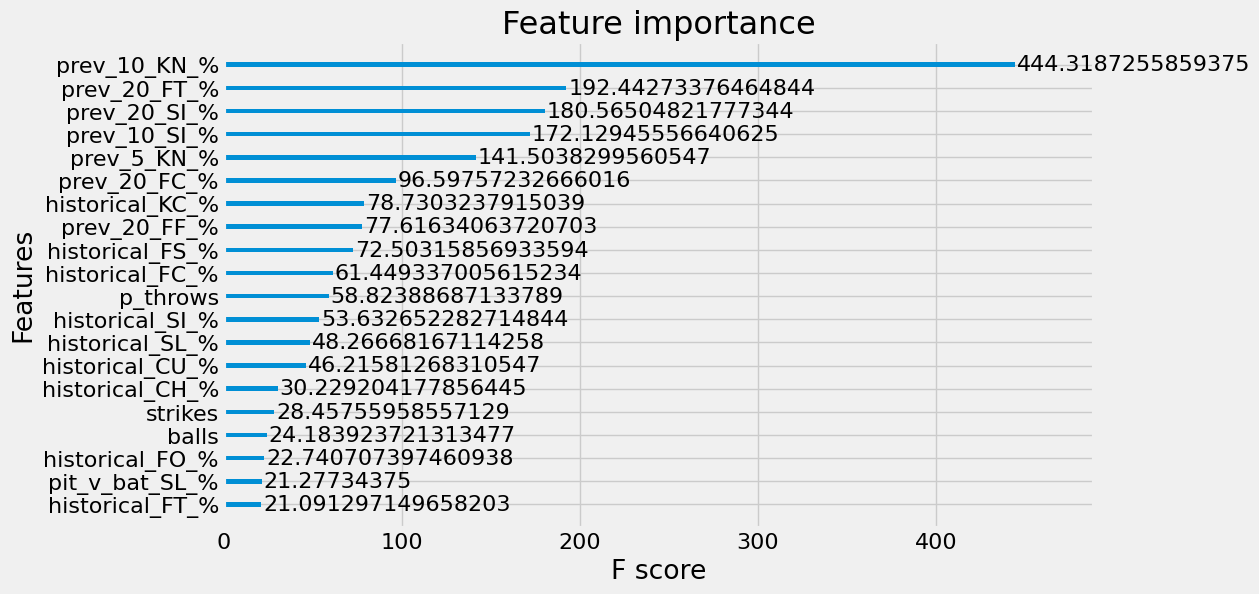

In [35]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax1 = plt.subplots(1,1, figsize=(10,6))
plot_importance(clf, importance_type='gain', max_num_features=20, ax=ax1)
plt.savefig(f"{DIRECTORY_PATH}/feature_importance.png")
plt.show()

In [36]:
''' 
Checking outputs
'''

' \nChecking outputs\n'

In [41]:
def view_pitcher_results(pitcher_id, training_set, validation_set, filepath=None):
    pid = pitcher_id
    num_in_training = training_set.query("pitcher_id == @pid").shape[0]
    num_in_validation = validation_set.query("pitcher_id == @pid").shape[0]

    training_pitch_type_rates = training_set.query("pitcher_id == @pid").pitch_type.value_counts(normalize=True)
    #validation_pitch_type_rates = training_set.query("pitcher_id == @pid").pitch_type.value_counts(normalize=True)

    predictions = clf.predict(val_X.query("pitcher_id == @pid"))
    true_vals = validation_set.query("pitcher_id == @pid")['pitch_type'].map(mapping)
    pitcher_confusion_matrix = confusion_matrix(true_vals, predictions, labels=list(mapping.values()))

    if filepath is None:
        print(f"Num instances of pitcher {pid} in training set = {num_in_training}")
        print(f"Num instances of pitcher {pid} in validation set = {num_in_validation}")
        print(f"Training rates = \n {pd.DataFrame(training_pitch_type_rates).T} ")

        print(f"Confusion matrix for Pitcher {pid} :")
        print(f"{pd.DataFrame(pitcher_confusion_matrix, columns=list(mapping.keys()), index=list(mapping.keys()))}")
        print(f"Classification Report : ")
        print(classification_report(true_vals, predictions, zero_division=np.nan))
    else:
        with open(filepath, "a") as text_file:
            print(f'\n------------------ Pitcher {pid}: -----------------\n', file=text_file)
            print(f"Training n = {num_in_training}", file=text_file)
            print(f"Val n = {num_in_validation}", file=text_file)
            print(f"Training rates = \n {pd.DataFrame(training_pitch_type_rates).T} ", file=text_file)

            print(f"Confusion matrix for Pitcher {pid} :", file=text_file)
            print(f"{pd.DataFrame(pitcher_confusion_matrix, columns=list(mapping.keys()), index=list(mapping.keys()))}", file=text_file)
            print(f"Classification Report : ", file=text_file)
            print(classification_report(true_vals, predictions, zero_division=np.nan), file=text_file)
    

In [42]:
view_pitcher_results(407819, training_set, validation_set)
view_pitcher_results(407819, training_set, validation_set, MODEL_INFO_FILEPATH)

UndefinedVariableError: name 'pitcher_id' is not defined

In [ ]:
# does well in case where little diversity
view_pitcher_results(547973, training_set, validation_set)
view_pitcher_results(547973, training_set, validation_set, MODEL_INFO_FILEPATH)

Num instances of pitcher 547973 in training set = 661
Num instances of pitcher 547973 in validation set = 107
Training rates = 
 pitch_type       FF        SL        CH   CU   EP   FC   FO   FS   FT   KC  \
proportion  0.83056  0.163389  0.006051  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

pitch_type   KN   SC   SI  
proportion  0.0  0.0  0.0   
Confusion matrix for Pitcher 547973 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF  90   1   0   0   0   0   0   0   0   0   0   0   0
SL  16   0   0   0   0   0   0   0   0   0   0   0   0
CU   0   0   0   0   0   0   0   0   0   0   0   0   0
SI   0   0   0   0   0   0   0   0   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   0   0   0   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0   0   0
FO   0   0   0

In [ ]:
# view pitcher with no four seam
view_pitcher_results(599899, training_set, validation_set)
view_pitcher_results(599899, training_set, validation_set, MODEL_INFO_FILEPATH)


Num instances of pitcher 599899 in training set = 637
Num instances of pitcher 599899 in validation set = 54
Training rates = 
 pitch_type        SI        CU        SC        SL        CH   EP   FC   FF  \
proportion  0.547881  0.295133  0.076923  0.051805  0.028257  0.0  0.0  0.0   

pitch_type   FO   FS   FT   KC   KN  
proportion  0.0  0.0  0.0  0.0  0.0   
Confusion matrix for Pitcher 599899 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF   0   0   0   0   0   0   0   0   0   0   0   0   0
SL   0   0   0   7   0   0   0   0   0   0   0   0   0
CU   0   0   4  17   0   0   0   0   0   0   0   0   0
SI   0   0   4  17   0   0   0   0   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   0   0   1   1   0   0   0   1   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0  

In [ ]:

view_pitcher_results(115817, training_set, validation_set)
view_pitcher_results(115817, training_set, validation_set, MODEL_INFO_FILEPATH)

Num instances of pitcher 115817 in training set = 2483
Num instances of pitcher 115817 in validation set = 179
Training rates = 
 pitch_type        SI        SL        CU        FF        CH   EP   FC   FO  \
proportion  0.353605  0.271043  0.153443  0.123238  0.098671  0.0  0.0  0.0   

pitch_type   FS   FT   KC   KN   SC  
proportion  0.0  0.0  0.0  0.0  0.0   
Confusion matrix for Pitcher 115817 :
    FF  SL  CU  SI  FC  FT  KC  CH  KN  FS  FO  EP  SC
FF  11  16   1  13   0   0   0   2   0   0   0   0   0
SL   4  29   1  12   0   0   0   2   0   0   0   0   0
CU   1   7   4   6   0   0   0   1   0   0   0   0   0
SI   2  20   2  26   0   0   0   3   0   0   0   0   0
FC   0   0   0   0   0   0   0   0   0   0   0   0   0
FT   0   0   0   0   0   0   0   0   0   0   0   0   0
KC   0   0   0   0   0   0   0   0   0   0   0   0   0
CH   2   2   2  10   0   0   0   0   0   0   0   0   0
KN   0   0   0   0   0   0   0   0   0   0   0   0   0
FS   0   0   0   0   0   0   0   0   0   0   0